# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [11]:
#Import all the required libraries
import tensorflow as tf
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate,LSTM,TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector
from keras import applications
import os
import numpy as np
import pandas as pd
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam
import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io
from skimage.transform import resize
from PIL import Image
from collections import Counter,defaultdict
import copy
import time
random.seed(42)
%config Completer.use_jedi = False

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [311]:
#Import the dataset and read the image into a seperate variable

images='../input/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


A child in a pink dress is climbing up a set of stairs in an entry way .


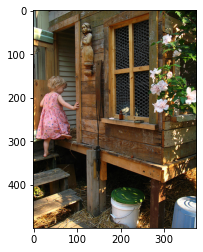

In [312]:
#Visualise both the images & text present in the dataset

text_file='../input/flickr8k/captions.txt' 
captions_and_image_name = open(text_file, 'r').readlines()[1:] # Reading the captions for each image from the captions text file
captions_and_image_name=[val.strip(' \n') for val in captions_and_image_name]
img_id= [val.split(",",maxsplit=1)[0] for val in captions_and_image_name] # Creating a list of all image files
img_path_id = [images+"/"+val for val in img_id] # Creating a list of all the image path
annot = [idx.split(",",maxsplit=1)[1] for idx in captions_and_image_name] # Creating a list of captions
plt.imshow(io.imread(img_path_id[0])) # Plotting an image
print(annot[0]) # Printing the corresponding caption.

In [313]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    raw_text = open(filename, 'r').readlines()[1:] # Reading the captions for each image from the captions text file
    text = [val.strip(' \n') for val in raw_text]
    return text

doc = load_doc(text_file)
print(doc[:300])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .', '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', '

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [314]:
all_img_id= [val.split(",",maxsplit=1)[0] for val in doc]  #store all the image id here
all_img_vector= [images+"/"+val for val in all_img_id] #store all the image path here
annotations= [idx.split(",",maxsplit=1)[1] for idx in doc]#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,../input/flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [315]:
#Create the vocabulary & the counter for the captions

vocabulary= [word for val in annotations for word in val.split(" ")] 

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

<AxesSubplot:title={'center':'Top 30 occuring words'}, xlabel='Word', ylabel='Count'>

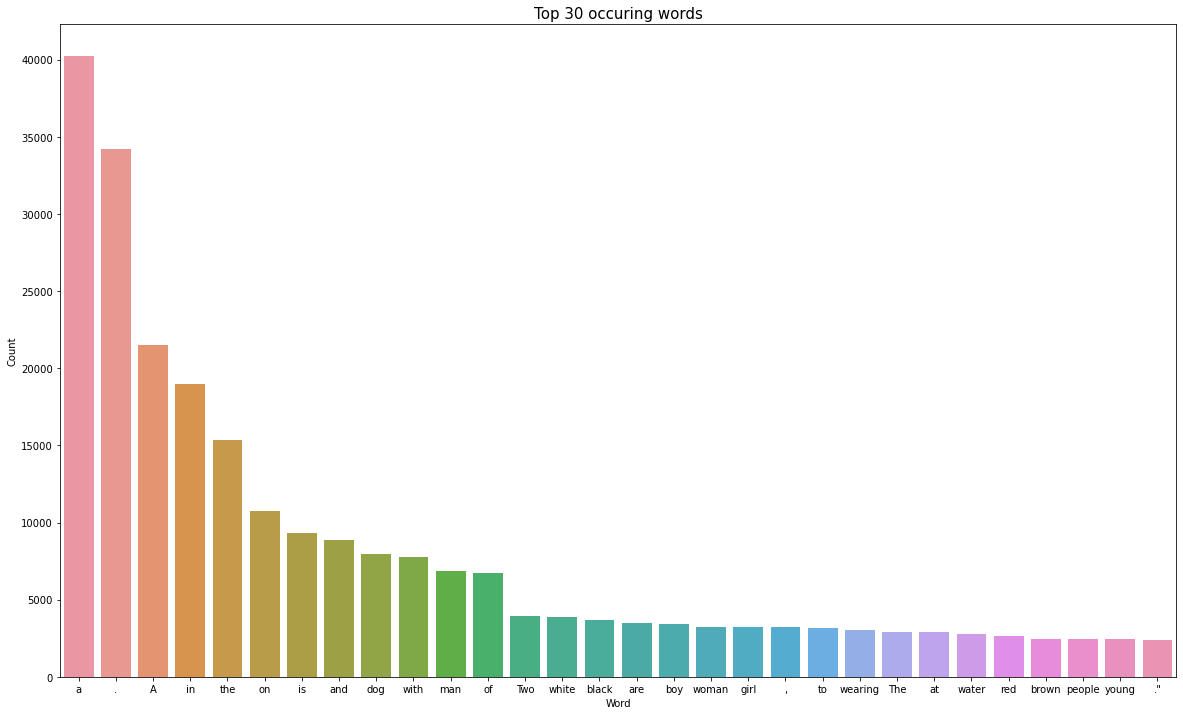

In [316]:
#Visualise the top 30 occuring words in the captions

Top_30 = pd.DataFrame(val_count.most_common(30),columns=["Word","Count"])

#write your code here
plt.figure(figsize=(20,12))
plt.title("Top 30 occuring words",size=15)
plt.xticks(fontsize=10)
sns.barplot(x=Top_30.Word,y=Top_30.Count)

In [317]:
annotations

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

In [318]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well

annotation=["<start> "+val+" <end>" for val in annotations] # Adding start and end token to the annotations

#Create a list which contains all the path to the images

all_img_path=list(set(all_img_vector))

print(f"Total captions present in the dataset: {len(annotation)}")
print(f"Total images present in the dataset: {len(all_img_path)}")

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [319]:
# create the tokenizer

#your code here
top_k = 5000

train_captions=copy.deepcopy(annotation)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<UNK>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [320]:
# Create word-to-index and index-to-word mappings.

#your code here
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
Word_seqs = tokenizer.texts_to_sequences(train_captions)

<AxesSubplot:title={'center':'Top 30 occuring words'}>

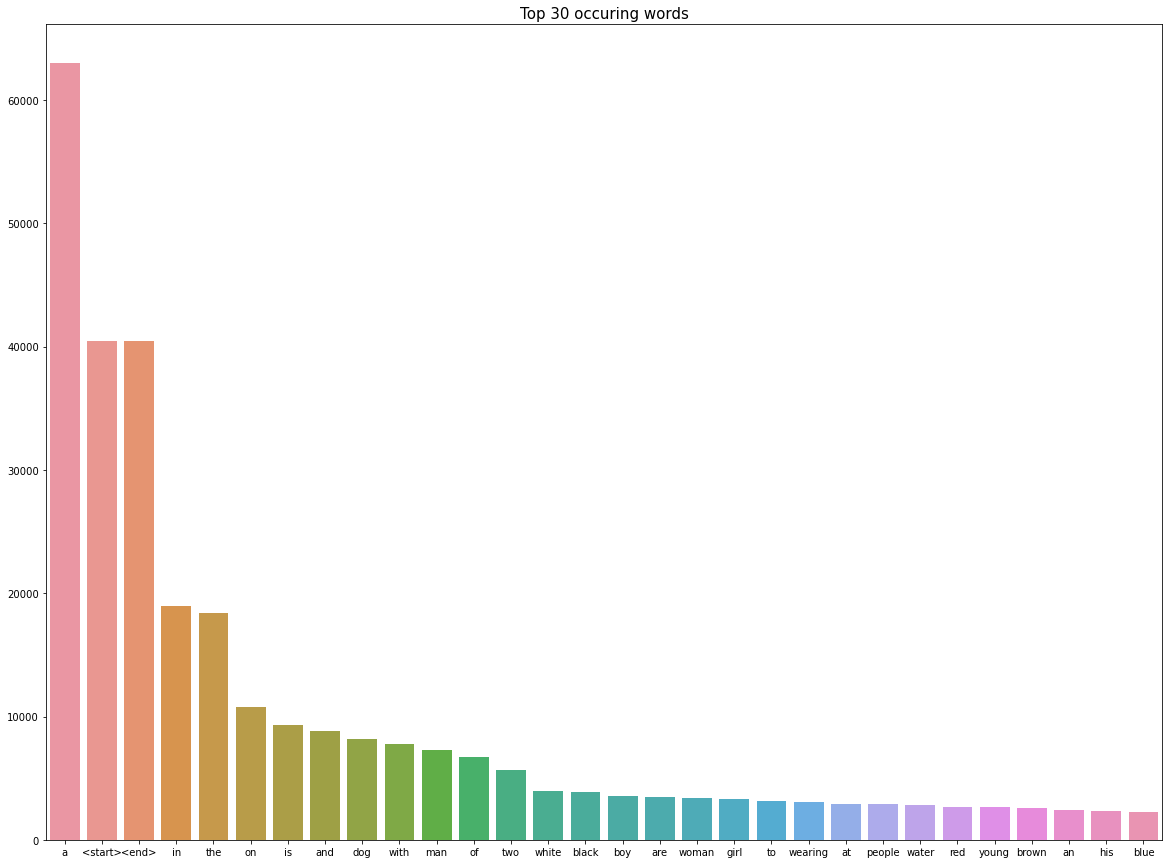

In [321]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

values=[idx[1] for idx in sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)][:30]
keys=[idx[0] for idx in sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)][:30]
plt.figure(figsize=(20,15))
plt.title("Top 30 occuring words",size=15)
sns.barplot(x=keys,y=values)

In [322]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(Word_seqs, padding='post')

max_length=39

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [323]:
#write your code here
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [324]:
#write your code here
BATCH_SIZE=50
BUFFER_SIZE = 1000
embedding_dim = 256


image_caption_dict=defaultdict(list)
for key,val in zip(df['Path'],cap_vector):
    image_caption_dict[key].append(val)

paths_images=list(image_caption_dict.keys())
random.seed(42)
random.shuffle(paths_images)


slice_index = int(len(paths_images)*0.8)
img_name_train_keys, img_name_val_keys = paths_images[:slice_index], paths_images[slice_index:]

img_train=[]
cap_train=[]
for i in img_name_train_keys:
    img_train.extend([i]*5)
    cap_train.extend(image_caption_dict[i])

img_test=[]
cap_test=[]
for i in img_name_val_keys:
    img_test.extend([i]*5)
    cap_test.extend(image_caption_dict[i])

    
def map_func(img_name, cap):
    img_tensor=load_image(img_name)[0]
    return img_tensor,np.ndarray.astype(cap,np.int32)    
    
    

    
    
train_dataset=tf.data.Dataset.from_tensor_slices((img_train,cap_train))
test_dataset=tf.data.Dataset.from_tensor_slices((img_test,cap_test))

train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)



train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)



test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [325]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(50, 299, 299, 3)
(50, 39)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [326]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [327]:
# write your code to extract features from each image in the dataset


# When you will pass an image from train/test set to the InceptionLayerV3 feature extractor, the output will be of size:- (batch size,8,8,2048). This dimension will be converted to (batch size,64,2048) before it is fed into the RNN Decoder. 
def feature_extraction(image,caption):
    feature_batch=image_features_extract_model(image)
    feature_batch = tf.reshape(feature_batch,
                              (feature_batch.shape[0], -1, feature_batch.shape[3]))
    return feature_batch,caption


train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          feature_extraction, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

In [328]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(50, 64, 2048)
(50, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [329]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps =len(img_train)//BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test)//BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [330]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [331]:
encoder=Encoder(embedding_dim)

### Attention model

In [332]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis))) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [333]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [334]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [335]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (50, 64, 256)
Predcitions shape from Decoder: (50, 5001)
Attention weights shape from Decoder: (50, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [336]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [337]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [338]:
checkpoint_path = "./training_checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [339]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [340]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
            
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
   
    return loss, avg_loss

In [341]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden= decoder.init_state(batch_size=target.shape[0])
    #write your code here to do the testing steps
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    feature_batch=image_features_extract_model(img_tensor)
    feature_batch = tf.reshape(feature_batch,
                              (feature_batch.shape[0], -1, feature_batch.shape[3]))
    features=encoder(feature_batch)
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        predictions=tf.random.categorical(predictions, 1).numpy()
        dec_input = predictions
            
    avg_loss = (loss / max_length)
    
        
    return loss, avg_loss

In [342]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        loss, average_loss = test_step(img_tensor, target)
        total_loss += average_loss
    avg_test_loss=(total_loss/test_num_steps)
    return avg_test_loss

In [343]:
tf.config.run_functions_eagerly(True)

In [344]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

For epoch: 1, the train loss is 1.240, & test loss is 2.698
Time taken for 1 epoch 742.4369900226593 sec

Test loss has been reduced from 100.000 to 2.698
For epoch: 2, the train loss is 0.972, & test loss is 2.784
Time taken for 1 epoch 738.7215301990509 sec

For epoch: 3, the train loss is 0.882, & test loss is 2.842
Time taken for 1 epoch 742.567595243454 sec

For epoch: 4, the train loss is 0.819, & test loss is 2.945
Time taken for 1 epoch 741.82874584198 sec

For epoch: 5, the train loss is 0.767, & test loss is 2.974
Time taken for 1 epoch 733.9193317890167 sec

For epoch: 6, the train loss is 0.722, & test loss is 3.071
Time taken for 1 epoch 728.4114050865173 sec

For epoch: 7, the train loss is 0.683, & test loss is 3.070
Time taken for 1 epoch 748.5965366363525 sec

For epoch: 8, the train loss is 0.645, & test loss is 3.203
Time taken for 1 epoch 750.5589053630829 sec

For epoch: 9, the train loss is 0.611, & test loss is 3.301
Time taken for 1 epoch 744.3900754451752 sec



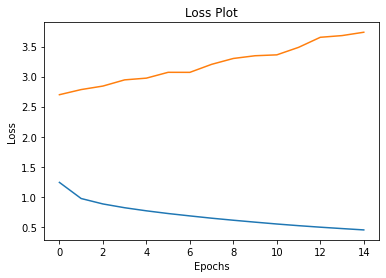

In [345]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [2]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
'''def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption'''



In [4]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [5]:
from nltk.translate.bleu_score import sentence_bleu

In [6]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 68.65890479690393
Real Caption: a black dog crossing a stream
Prediction Caption: a brown dog is turning out of the river


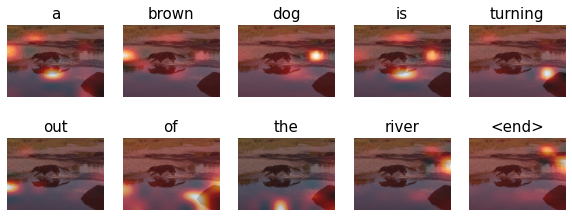

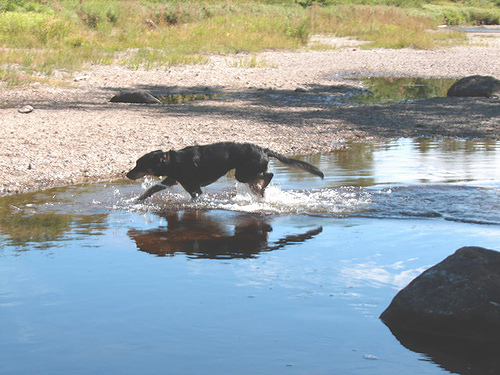

In [364]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [1]:
!pip install gTTS

In [ ]:

# Import the required module for text 
# to speech conversion
from gtts import gTTS
  
# This module is imported so that we can 
# play the converted audio
import os
  
# The text that you want to convert to audio
mytext = pred_caption
  
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
# here we have marked slow=False. Which tells 
# the module that the converted audio should 
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
# welcome 
myobj.save("captions.mp3")
  
# Playing the converted file
os.system("mpg321 captions.mp3")

In [ ]:
#captions=beam_evaluate(test_image)
#print(captions)